## Implications of ignoring permeability -- some inversions

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase

# SimPEG, discretize/
import discretize
from SimPEG.electromagnetics import time_domain as tdem
from SimPEG import (
    maps, Report, data_misfit, regularization, 
    optimization, inverse_problem, 
    inversion, directives
)
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim
import utils

In [2]:
path_to_data = "/t40array/lheagy/casing-permeability"
directory = f"{path_to_data}/fields_permeability"

In [3]:
mesh = discretize.load_mesh(f"{directory}/mesh.json")
times = np.load(f"{directory}/times.npy")

In [4]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-1
sigma_casing = 5e6
mur_casing = np.r_[1, 50, 100, 150, 200]

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = 500

In [5]:
return_electrode_r = 500
src_a = np.r_[casing_a+casing_t/2, 0, 0]
src_b = np.r_[return_electrode_r, 0., 0.]

In [6]:
inds_casing = utils.get_casing_inds(mesh, casing_a, casing_b, casing_l)

In [7]:
halfspace_conductivity = sigma_back * np.ones(mesh.n_cells)
halfspace_conductivity[mesh.cell_centers[:, 2] > 0] = sigma_air

casing_conductivity = halfspace_conductivity.copy()
casing_conductivity[inds_casing] = sigma_casing

casing_mur_models = {
}

keys = [f"casing_{mur}" for mur in mur_casing]
for key, mur in zip(keys, mur_casing): 
    casing_mur = np.ones(mesh.n_cells)
    casing_mur[inds_casing] = mur
    casing_mur_models[key] = casing_mur

## load fields, create simulation

In [8]:
# top casing source 
src_theta = np.pi / 2. + mesh.h[1][0]/2.
src_a = np.r_[casing_b - mesh.h[0].min()/2, src_theta, -mesh.h[2].min()/2]
src_b = np.r_[return_electrode_r, src_theta, -mesh.h[2].min()/2]
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, mesh.h[2].min()*1.5], src_b+np.r_[0, 0, mesh.h[2].min()*1.5], src_b
    ]
)

In [9]:
rx_x = mesh.cell_centers_x[50:78]
rx_y = mesh.cell_centers_y[0]
rx_z = np.r_[-0.1] # just below the surface

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])

rx_times = times[55::10]
print(len(rx_times), rx_times.min(), rx_times.max())

37 0.00010500000000000007 1.0433200000000007


In [10]:
rx = tdem.receivers.PointElectricField(
    locations=rx_locs, orientation="x", times=rx_times
)
src = tdem.sources.LineCurrent([rx], location=src_locations)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DCurrentDensity(
    mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
    survey=survey, solver=Pardiso, time_steps=np.diff(times), 
#     verbose=True
)


In [11]:
np.all(sim.times == times)

True

In [12]:
keys

['casing_1', 'casing_50', 'casing_100', 'casing_150', 'casing_200']

In [13]:
fields = {}
for key in keys:
    fields[key] = utils.load_fields(
        f"{directory}/fields_casing_{key.split('_')[-1]}", sim, 
        casing_conductivity, casing_mur_models[key]*mu_0
    )

/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [14]:
dobs = {}
for key, f in fields.items():
    sim.mu = casing_mur_models[key] * mu_0
    dobs[key] = sim.make_synthetic_data(
        casing_conductivity, relative_error=0.05, noise_floor=1e-8,
        f=f, add_noise=False
    )

/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylindricalMesh.getInterpolationMat has been deprecated, please use CylindricalMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: TensorMesh.getInterpolationMat has been deprecated, please use TensorMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [15]:
val = dobs[keys[0]]
print(val.nD)

1036


Text(0.5, 0, 'time (ms)')

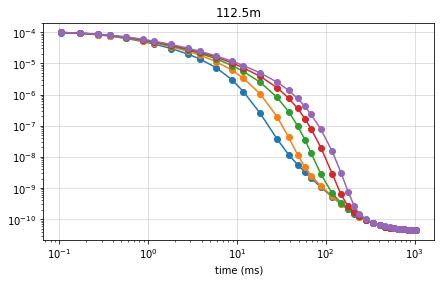

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

spatial_ind = 8

for key, val in dobs.items():
    d = val.dobs.reshape(len(rx_x), len(rx_times), order="F")
    ax.loglog(rx_times*1e3, np.abs(d[spatial_ind, :]), "-o", label=key)
ax.grid(alpha=0.5)
ax.set_title(f"{rx_x[spatial_ind]:1.1f}m")
ax.set_xlabel("time (ms)")

# example 1: impacts on casing integrity estimation

- take mu0 = 150, see what we recover for length
- parametric casing & layer 
```
m = [
     val_background,
     val_layer,
     val_casing,
     val_insideCasing,
     layer_center,
     layer_thickness,
     casing_radius,
     casing_thickness,
     casing_bottom,
     casing_top
]
```

In [17]:
csz = 5
npadz = 15
pf = 1.5

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=11,
    csx2=25,
    domain_x=return_electrode_r
)

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = casing_l/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# create the mesh
inv_mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print(inv_mesh.n_cells)

137280


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


[<PolarAxesSubplot:>, <AxesSubplot:xlabel='x', ylabel='z'>]

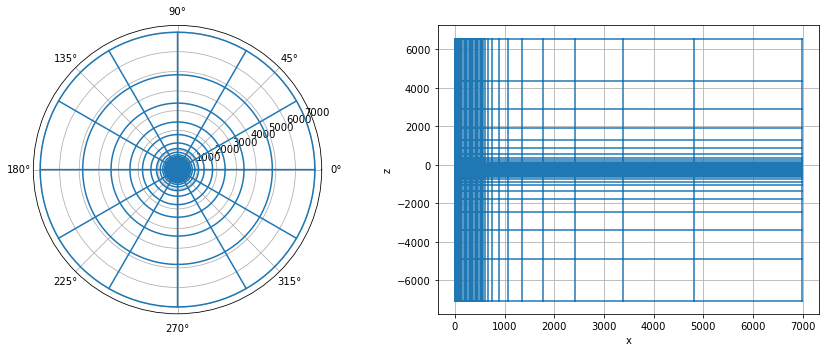

In [18]:
inv_mesh.plot_grid()

In [19]:
active_inds_casing_model = np.zeros(10, dtype=bool)
active_inds_casing_model[8] = True
parametric_casing_model = np.r_[
    np.log(sigma_back), np.log(sigma_back), 
    np.log(sigma_casing), np.log(sigma_back), 
    np.r_[-20], np.r_[1],
    (casing_a+casing_b)/2, casing_t, -casing_l, np.r_[0]
]
subsurface_cells = inv_mesh.cell_centers[:, 2] < 0

active_model_params = maps.InjectActiveCells(
    inv_mesh, indActive=active_inds_casing_model, 
    valInactive=parametric_casing_model[~active_inds_casing_model],
    nC=10
)
casing_map = maps.ParametricCasingAndLayer(
    inv_mesh, indActive=subsurface_cells, slope=1e5
)
inject_air_cells = maps.InjectActiveCells(
    inv_mesh, indActive=subsurface_cells, valInactive=np.log(sigma_air)
)
exp_map = maps.ExpMap(inv_mesh)

casing_integrity_mapping = exp_map * inject_air_cells * casing_map * active_model_params

In [20]:
sigma_test = casing_integrity_mapping * np.r_[-casing_l]
sigma_test.max()

active_model_params.valInactive[2] = np.log(sigma_casing * (sigma_casing / sigma_test.max()))
test = casing_integrity_mapping * np.r_[-casing_l]
print(test.max())

4999836.609391265


In [21]:
casing_integrity_mapping.test(np.r_[-casing_l])

Testing ComboMap[ComboMap[ComboMap[ExpMap(137280,137280) * InjectActiveCells(137280,121440)](137280,121440) * ParametricCasingAndLayer(121440,10)](137280,10) * InjectActiveCells(10,1)](137280,1)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: checkDerivative has been deprecated, please use check_derivative. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


 0   1.00e-01    1.114e+00     1.590e-03      nan
 1   1.00e-02    1.115e-01     1.607e-05      1.995
 2   1.00e-03    1.115e-02     7.098e-07      1.355
 3   1.00e-04    1.115e-03     6.670e-07      0.027
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
It might be easier to call this a feature...



False

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:140: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0

(-700.0, 50.0)

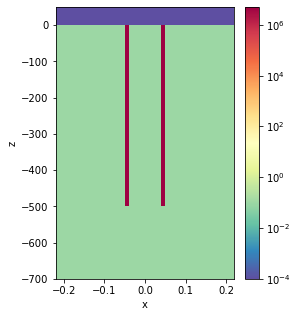

In [22]:
xlim = 0.22*np.r_[-1, 1]
zlim = np.r_[-700, 50]
pcolor_opts={"norm":LogNorm(vmin=sigma_air, vmax=sigma_casing), "cmap":"Spectral_r"}

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
out = casing_sim.view.plot_slice(
    inv_mesh, sigma_test, pcolor_opts=pcolor_opts, ax=ax
)
ax.set_xlim(xlim)
ax.set_ylim(zlim)

In [23]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[0],
            "phi_d":[self.invProb.phi_d],
            "dpred":[np.nan * np.ones(inv.invProb.dmisfit.nD)],
            "model":[self.invProb.model]
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["model"].append(self.invProb.model)

In [24]:
inv_simulation = tdem.simulation.Simulation3DCurrentDensity(
    mesh=inv_mesh, sigmaMap=casing_integrity_mapping,
    survey=survey, solver=Pardiso, time_steps=np.diff(times), 
)

key = "casing_150"
dmis = data_misfit.L2DataMisfit(dobs[key], inv_simulation)

In [25]:
r = (dobs[key].dobs - dobs["casing_1"].dobs)
Wr = dmis.W * r
Wr.dot(Wr)

44423.818382140314

In [26]:
dmis.nD

1036

In [27]:
reg = regularization.Tikhonov(discretize.TensorMesh([1]))

opt = optimization.InexactGaussNewton(maxIter=10, maxIterCG=20)
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0)

target = directives.TargetMisfit(chifact=1)
progress = SaveInversionProgress()
inv = inversion.BaseInversion(
    inv_prob, directiveList=[target, progress]
)

In [28]:
mrec = inv.run(np.r_[-200])

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


/home/lheagy/.conda/envs/casing/lib/python3.9/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vol has been deprecated, please use CylindricalMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.faceDiv has been deprecated, please use CylindricalMesh.face_divergence. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpe

   0  0.00e+00  5.92e+04  0.00e+00  5.92e+04    2.51e-06      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 1.0000e+00 <= tolF*(1+|f0|) = 0.0000e+00
0 : |xc-x_last| = 1.0000e+00 <= tolX*(1+|x0|) = 0.0000e+00
1 : |proj(x-g)-x|    = 2.5077e-06 <= tolG          = 1.0000e-01
1 : |proj(x-g)-x|    = 2.5077e-06 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      0
------------------------- DONE! -------------------------


In [29]:
mrec

array([-200])

## example 2: impacts on estimating the background conductivity



In [30]:
active_inds_casing_model = np.zeros(10, dtype=bool)
active_inds_casing_model[0] = True
parametric_casing_model = np.r_[
    np.log(sigma_back), np.log(sigma_back), 
    np.log(sigma_casing), np.log(sigma_back), 
    np.r_[-20], np.r_[1],
    (casing_a+casing_b)/2, casing_t, -casing_l, np.r_[0]
]
subsurface_cells = inv_mesh.cell_centers[:, 2] < 0

active_model_params = maps.InjectActiveCells(
    inv_mesh, indActive=active_inds_casing_model, 
    valInactive=parametric_casing_model[~active_inds_casing_model],
    nC=10
)
casing_map = maps.ParametricCasingAndLayer(
    inv_mesh, indActive=subsurface_cells, slope=1e5
)
inject_air_cells = maps.InjectActiveCells(
    inv_mesh, indActive=subsurface_cells, valInactive=np.log(sigma_air)
)
exp_map = maps.ExpMap(inv_mesh)

casing_background_mapping = exp_map * inject_air_cells * casing_map * active_model_params

In [31]:
sigma_test = casing_background_mapping * np.r_[np.log(sigma_back)]

active_model_params.valInactive[2] = np.log(sigma_casing * (sigma_casing / sigma_test.max()))
test = casing_background_mapping * np.r_[np.log(sigma_back)]
print(test.max())

4999836.609391265


In [32]:
casing_background_mapping.test(np.r_[np.log(sigma_back)])

Testing ComboMap[ComboMap[ComboMap[ExpMap(137280,137280) * InjectActiveCells(137280,121440)](137280,121440) * ParametricCasingAndLayer(121440,10)](137280,10) * InjectActiveCells(10,1)](137280,1)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    6.054e+04     9.292e+00      nan
 1   1.00e-02    6.055e+03     9.294e-02      2.000
 2   1.00e-03    6.055e+02     9.291e-04      2.000
 3   1.00e-04    6.055e+01     8.958e-06      2.016
========================= PASS! =========================
Once upon a time, a happy little test passed.



True

(-700.0, 50.0)

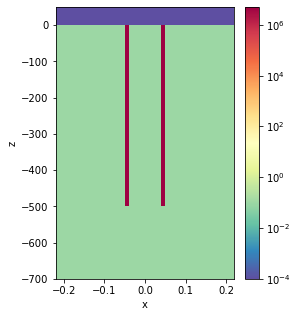

In [33]:
xlim = 0.22*np.r_[-1, 1]
zlim = np.r_[-700, 50]
pcolor_opts={"norm":LogNorm(vmin=sigma_air, vmax=sigma_casing), "cmap":"Spectral_r"}

fig, ax = plt.subplots(1, 1, figsize=(4, 5))
out = casing_sim.view.plot_slice(
    inv_mesh, casing_background_mapping * np.r_[np.log(1e-1)], pcolor_opts=pcolor_opts, ax=ax
)
ax.set_xlim(xlim)
ax.set_ylim(zlim)

In [34]:
rx = tdem.receivers.PointElectricField(
    locations=rx_locs, orientation="x", times=rx_times
)
src = tdem.sources.LineCurrent([rx], location=src_locations)
survey = tdem.Survey([src])

inv_simulation2 = tdem.simulation.Simulation3DCurrentDensity(
    mesh=inv_mesh, sigmaMap=casing_background_mapping,
    survey=survey, solver=Pardiso, time_steps=np.diff(times), 
)

key = "casing_150"
dmis2 = data_misfit.L2DataMisfit(dobs[key], inv_simulation2)

In [35]:
reg2 = regularization.Tikhonov(discretize.TensorMesh([1]))

opt2 = optimization.InexactGaussNewton(maxIter=10, maxIterCG=20)
inv_prob2 = inverse_problem.BaseInvProblem(dmis2, reg2, opt2, beta=0)

target2 = directives.TargetMisfit(chifact=1)
progress2 = SaveInversionProgress()
inv2 = inversion.BaseInversion(
    inv_prob2, directiveList=[target2, progress2]
)

In [36]:
mrec2 = inv2.run(np.r_[np.log(sigma_back)])

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  2.25e+04  0.00e+00  2.25e+04    9.40e+03      0              
   1  0.00e+00  2.22e+04  9.58e-09  2.22e+04    1.34e+03      0              
------------------------------------------------------------------
0 :    ft     = 2.2155e+04 <= alp*descent     = 2.2153e+04
1 : maxIterLS =      10    <= iterLS          =     10
------------------------- End Linesearch -------------------------
The linesearch got broken. Boo.


In [40]:
np.exp(mrec2)

array([0.11484684])

In [38]:
inv_simulation2.MfRhoIDeriv(

SyntaxError: unexpected EOF while parsing (3100435119.py, line 1)

In [ ]:
phi = inv_simulation2.survey.source_list[0].phiInitial(inv_simulation2)


In [ ]:
D = discretize.utils.sdiag(inv_simulation2.mesh.vol) * inv_simulation2.mesh.faceDiv
G = D.T
v = np.r_[np.log(sigma_back)]
Temp = inv_simulation2.MfRhoIDeriv(G * phi, v)

In [ ]:
tmp = inv_simulation2.rhoDeriv

In [ ]:
tmp.shape

In [ ]:
(tmp @ v).shape

In [ ]:
inv_simulation.rhoDeriv.shape

In [ ]:
inv_simulation2.MfRhoIDeriv??

In [ ]:
inv_simulation2.survey.source_list[0]._phiInitialDeriv(inv_simulation2, v)

In [ ]:
%debug

In [ ]:
casing_background_mapping.shape

In [ ]:
active_inds_casing_model = np.zeros(10, dtype=bool)
active_inds_casing_model[0] = True
active_inds_casing_model[8] = True

parametric_casing_model = np.r_[
    np.log(sigma_back), np.log(sigma_back), 
    np.log(sigma_casing), np.log(sigma_back), 
    np.r_[-20], np.r_[1],
    (casing_a+casing_b)/2, casing_t, -casing_l, np.r_[0]
]
subsurface_cells = inv_mesh.cell_centers[:, 2] < 0

active_model_params = maps.InjectActiveCells(
    inv_mesh, indActive=active_inds_casing_model, 
    valInactive=parametric_casing_model[~active_inds_casing_model],
    nC=10
)
casing_map = maps.ParametricCasingAndLayer(
    inv_mesh, indActive=subsurface_cells, slope=1e5
)
inject_air_cells = maps.InjectActiveCells(
    inv_mesh, indActive=subsurface_cells, valInactive=np.log(sigma_air)
)
exp_map = maps.ExpMap(inv_mesh)

both_mapping = exp_map * inject_air_cells * casing_map * active_model_params

In [ ]:
rx = tdem.receivers.PointElectricField(
    locations=rx_locs, orientation="x", times=rx_times
)
src = tdem.sources.LineCurrent([rx], location=src_locations)
survey = tdem.Survey([src])

inv_simulation3 = tdem.simulation.Simulation3DCurrentDensity(
    mesh=inv_mesh, sigmaMap=both_mapping,
    survey=survey, solver=Pardiso, time_steps=np.diff(times), 
)

key = "casing_150"
dmis3 = data_misfit.L2DataMisfit(dobs[key], inv_simulation3)

In [ ]:
reg3 = regularization.Tikhonov(discretize.TensorMesh([2]))

opt3 = optimization.InexactGaussNewton(maxIter=10, maxIterCG=20)
inv_prob3 = inverse_problem.BaseInvProblem(dmis3, reg3, opt3, beta=0)

target3 = directives.TargetMisfit(chifact=1)
progress3 = SaveInversionProgress()
inv3 = inversion.BaseInversion(
    inv_prob3, directiveList=[target3, progress3]
)

In [ ]:
mrec = inv3.run(np.r_[np.log(sigma_back), -casing_l])